# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir('/content/drive/MyDrive/UCL/STAT0035')

In [3]:
%%capture
!pip install dm-haiku

In [4]:
# use TPUs
# - https://github.com/google/jax/pull/8485/commits/61a3abbeab027d0b4ad868de1cbb6a542cd19c4a
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu('tpu_driver-0.1dev20211031')

# use float32 matmul on TPU
import jax
jax.config.update('jax_default_matmul_precision', 'highest')

# check the number of GPU / TPU devices
n_dev = jax.local_device_count() 
print('num. devices:', n_dev)

num. devices: 8


# imports

In [5]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

# relative imports
from core import models, distributions, datasets, utils, metrics, spmd
from core.sgd import train_sgd
from core.rwmh import rwmh_sampler
from core.hmc import hmc_sampler
from core.nuts import nuts_sampler
from core.spmd import spmd

In [6]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [7]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = datasets.load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


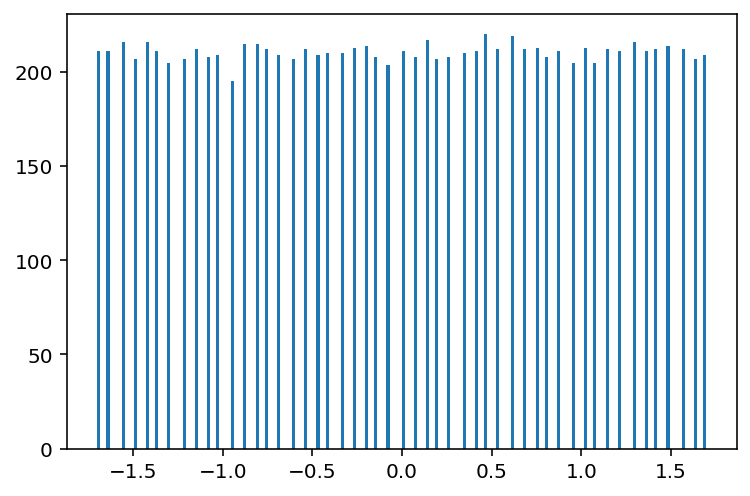

In [8]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [9]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 3*[50]
prior_sd = 1
init_sd = 0.1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
n_params = len(params_init)
params_init = init_sd*jax.random.normal(key, [n_params])
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior_fn(x_train, y_train, log_likelihood_fn, log_prior_fn)

In [10]:
# test model
print('num. params: ', n_params)
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init, x_train, y_train))

num. params:  5952
PDF test:  -5498.814 -16371.821


# training

In [11]:
# number of independent chains to create using each method
n_chains = 5

# number of samples to keep from each chain
n_samples = 100

# make dirs for storing output
os.makedirs('tmp', exist_ok=True)
os.makedirs('plots', exist_ok=True)

## SGD

In [12]:
%%time
n_epochs = 100_000
lr_start = 1e-6
lr_stop = 1e-9
key = jax.random.PRNGKey(0)

chains_sgd = jnp.zeros([n_chains, 1, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    params = init_sd*jax.random.normal(key, [n_params])
    params_sgd, loss_sgd, _ = spmd(train_sgd)(x_train, y_train, params, log_likelihood_fn, log_prior_fn, n_dev, n_epochs, lr_start, lr_stop)
    chains_sgd = chains_sgd.at[i].set(params_sgd[None])

jnp.save('tmp/sgd.npy', chains_sgd)

CPU times: user 15.2 s, sys: 33.2 s, total: 48.5 s
Wall time: 1min 22s


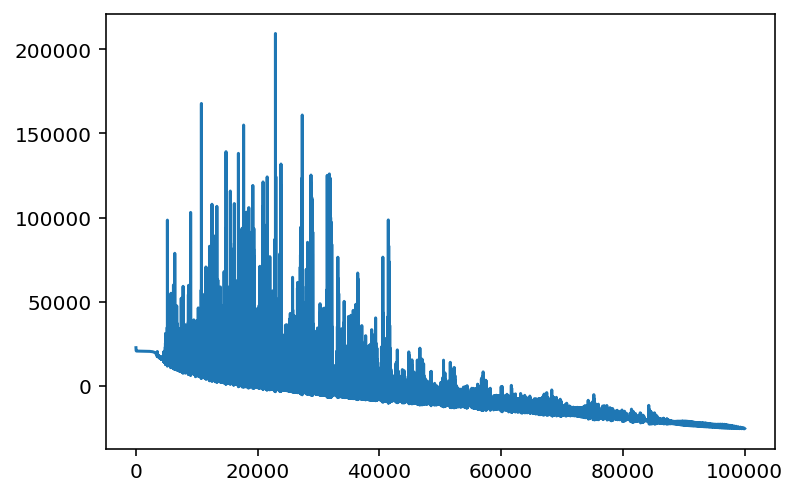

-25324.379


In [13]:
fig, ax = plt.subplots()
ax.plot(loss_sgd)
plt.show()
print(loss_sgd[-1])

## ensemble

In [14]:
%%time
ens_size = 8
assert ens_size == n_dev
key = jax.random.PRNGKey(0)

chains_ens = jnp.zeros([n_chains, ens_size, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    params = init_sd*jax.random.normal(key, [ens_size, n_params])
    f = lambda params: train_sgd(log_posterior_fn, params, n_epochs, lr_start, lr_stop)
    chain_ens, loss_history, _ = jax.pmap(f)(params)
    chains_ens = chains_ens.at[i].set(chain_ens)

jnp.save('tmp/ens.npy', chains_ens)

CPU times: user 41.8 s, sys: 2min 5s, total: 2min 47s
Wall time: 4min 54s


## RWMH

In [15]:
%%time
step_size = 2e-5
n_blind_steps = 30_000
key = jax.random.PRNGKey(0)

chains_rwmh = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_rwmh, avg_accept_prob = spmd(rwmh_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_blind_steps, step_size)
    chains_rwmh = chains_rwmh.at[i].set(chain_rwmh)
    print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

jnp.save('tmp/rwmh.npy', chains_rwmh)

Avg. accept. prob.: 18.42%
Avg. accept. prob.: 15.94%
Avg. accept. prob.: 19.61%
Avg. accept. prob.: 15.63%
Avg. accept. prob.: 19.61%
CPU times: user 2min 23s, sys: 7min 26s, total: 9min 49s
Wall time: 17min 30s


## HMC

In [16]:
%%time
hmc_step_size = 5e-7
n_leapfrog_steps = 10_000
key = jax.random.PRNGKey(0)

chains_hmc = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_hmc, avg_accept_prob = spmd(hmc_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, n_leapfrog_steps, hmc_step_size)
    chains_hmc = chains_hmc.at[i].set(chain_hmc)
    print(f'Avg. accept. prob.: {avg_accept_prob.mean():.2%}')

jnp.save('tmp/hmc.npy', chains_hmc)

Avg. accept. prob.: 81.69%
Avg. accept. prob.: 80.29%
Avg. accept. prob.: 83.18%
Avg. accept. prob.: 77.03%
Avg. accept. prob.: 86.18%
CPU times: user 3min 3s, sys: 9min 26s, total: 12min 29s
Wall time: 22min 2s


## NUTS

In [17]:
%%time
max_depth = 13
print('max leapfrog steps: ', 2**max_depth)
key = jax.random.PRNGKey(0)

chains_nuts = jnp.zeros([n_chains, n_samples, n_params])
for i in range(n_chains):
    key, _ = jax.random.split(key)
    chain_nuts, ratio_valid_samples, total_stops = spmd(nuts_sampler)(x_train, y_train, chains_sgd[i, 0], log_likelihood_fn, log_prior_fn, n_dev, key, n_samples, max_depth, hmc_step_size)
    chains_nuts = chains_nuts.at[i].set(chain_nuts)
    print(f'Proportion valid: {ratio_valid_samples.mean():.2%}')
    print(f'Termination: max_steps={total_stops[0]}, u-turn={total_stops[1]}, max_error={total_stops[2]}.')

jnp.save('tmp/nuts.npy', chains_nuts)

max leapfrog steps:  8192
Proportion valid: 99.00%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 99.59%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 97.98%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 98.29%
Termination: max_steps=100, u-turn=0, max_error=0.
Proportion valid: 98.20%
Termination: max_steps=100, u-turn=0, max_error=0.
CPU times: user 3min 31s, sys: 10min 53s, total: 14min 25s
Wall time: 25min 18s


# load training output

In [18]:
chains_sgd = jnp.load('tmp/sgd.npy', allow_pickle=True)
chains_ens = jnp.load('tmp/ens.npy', allow_pickle=True)
chains_rwmh = jnp.load('tmp/rwmh.npy', allow_pickle=True)
chains_hmc = jnp.load('tmp/hmc.npy', allow_pickle=True)
chains_nuts = jnp.load('tmp/nuts.npy', allow_pickle=True)

# diagnostics

In [19]:
burn_in = 20
chains_rwmh = chains_rwmh[:, burn_in:]
chains_hmc = chains_hmc[:, burn_in:]
chains_nuts = chains_nuts[:, burn_in:]

chains_dict = {
    'SGD': chains_sgd,
    'ensemble': chains_ens,
    'RWMH': chains_rwmh,
    'HMC': chains_hmc,
    'NUTS': chains_nuts,
}

for name, chain in chains_dict.items():
    print(name, chain.shape)

SGD (5, 1, 5952)
ensemble (5, 8, 5952)
RWMH (5, 80, 5952)
HMC (5, 80, 5952)
NUTS (5, 80, 5952)


## history of a single parameter

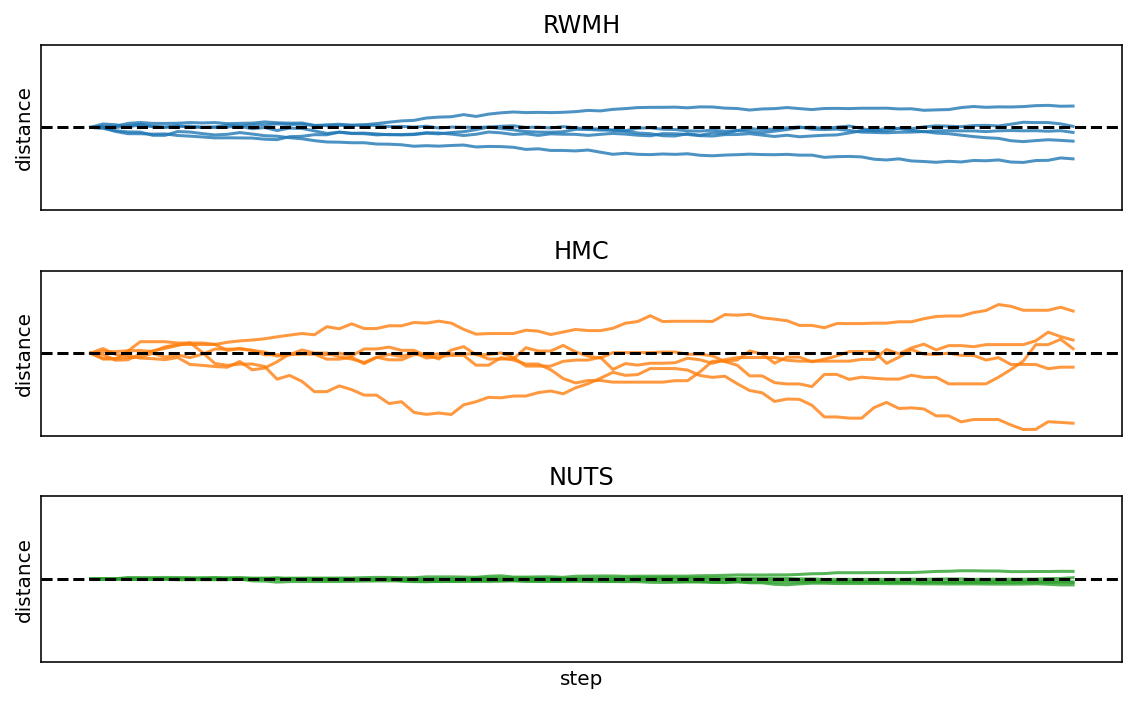

In [20]:
param_idx = 0
n_points = 100
y_range = 0.08
fig, axs = plt.subplots(3, 1, figsize=[8, 5])
axs = axs.flatten()
chains_to_show = ['RWMH', 'HMC', 'NUTS']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    for j in range(n_chains):
        y = chains[j, :n_points, param_idx]
        y -= y[0]
        axs[i].plot(y, '-', alpha=0.8, color=f'C{i}')
    axs[i].axhline(y=0, linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_ylim([-y_range, y_range])
    axs[i].set_ylabel('distance')
    axs[i].set_title(name)
    if i == 2: axs[i].set_xlabel('step')
plt.tight_layout()
plt.savefig('plots/uci_param_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

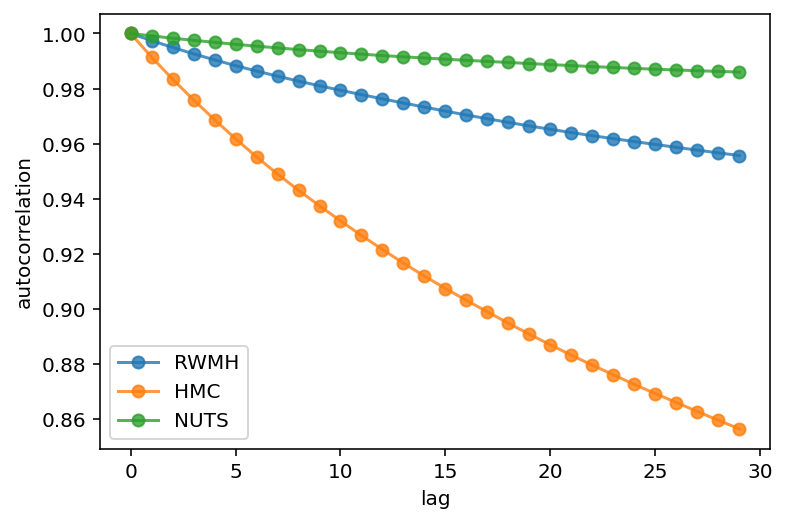

In [21]:
fig, ax = plt.subplots()
n_lags = 30

# autocorrelation
chains_to_show = ['RWMH', 'HMC', 'NUTS']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, n_lags)
    ax.plot(r, 'o-', alpha=0.8, label=name)
    # ax.axhline(y=0, color='black', linestyle="--")

ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')
plt.savefig('plots/uci_param_autocor.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## stdev of params

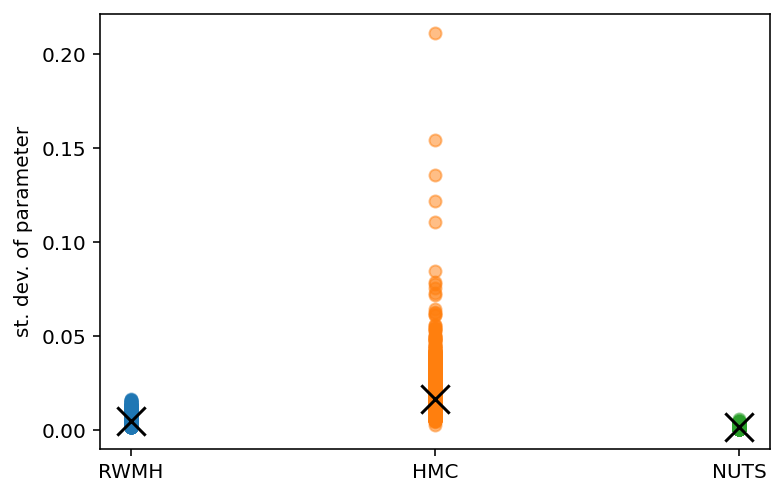

In [22]:
fig, ax = plt.subplots()

# R_hat
chains_to_show = ['RWMH', 'HMC', 'NUTS']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    chain = chains[0]
    r = chain.std(axis=0)
    ax.scatter([i]*len(r), r, alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('st. dev. of parameter')

plt.savefig('plots/uci_param_stdev.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## calibration

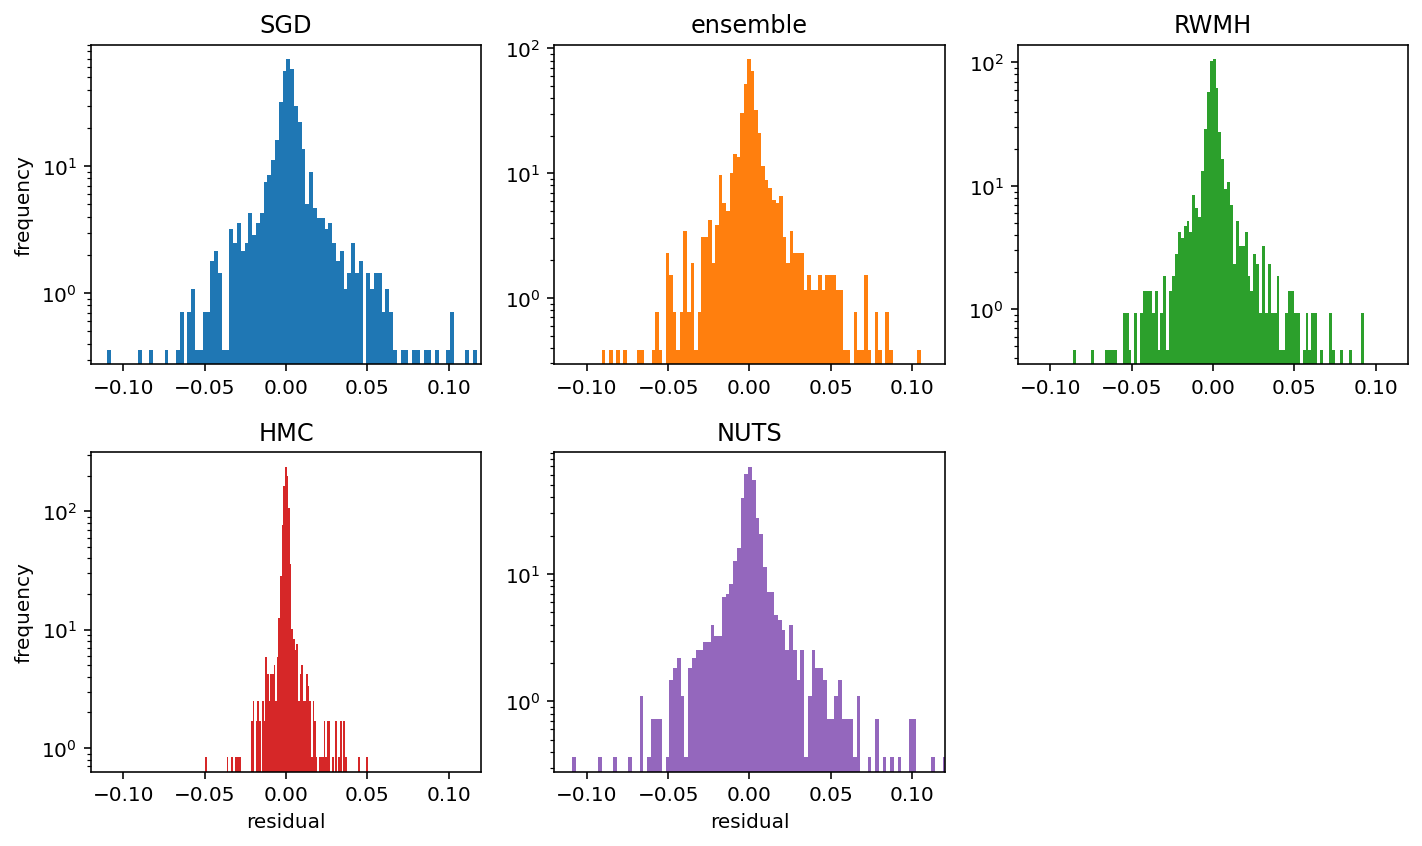

In [23]:
# residuals
def get_std_resid(chain):
    # average y_hat across nodes
    predict_vmap = jax.vmap(predict_fn, [None, 0])
    y_hat = predict_vmap(x_test, chain).mean(0)
    mean, std = y_hat[:, 0], y_hat[:, 1]

    # compute residuals
    std_resid = (y_test - mean)

    return std_resid

fig, axs = plt.subplots(2, 3, figsize=[10, 6])
axs = axs.flatten()
for i, (name, chains) in enumerate(chains_dict.items()):
    chain = chains.reshape([-1, n_params])
    std_resid = get_std_resid(chain)
    axs[i].hist(std_resid.tolist(), bins=100, density=True, color=f'C{i}')
    axs[i].set_xlim([-0.12, 0.12])
    axs[i].set_yscale('log')
    axs[i].set_title(name)
    if i in [3, 4]: axs[i].set_xlabel('residual')
    if i in [0, 3]: axs[i].set_ylabel('frequency')

axs[-1].axis('off')
plt.tight_layout()
plt.savefig('plots/uci_residuals_hist.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

In [24]:
# p-values of the true response values
def get_response_pvals(key, chain, n_samples=100_000):    
    samples = utils.sample_from_chain(predict_fn, key, x_test, chain, n_samples)
    quantiles = (samples < y_test[:, None]).mean(1)
    return quantiles

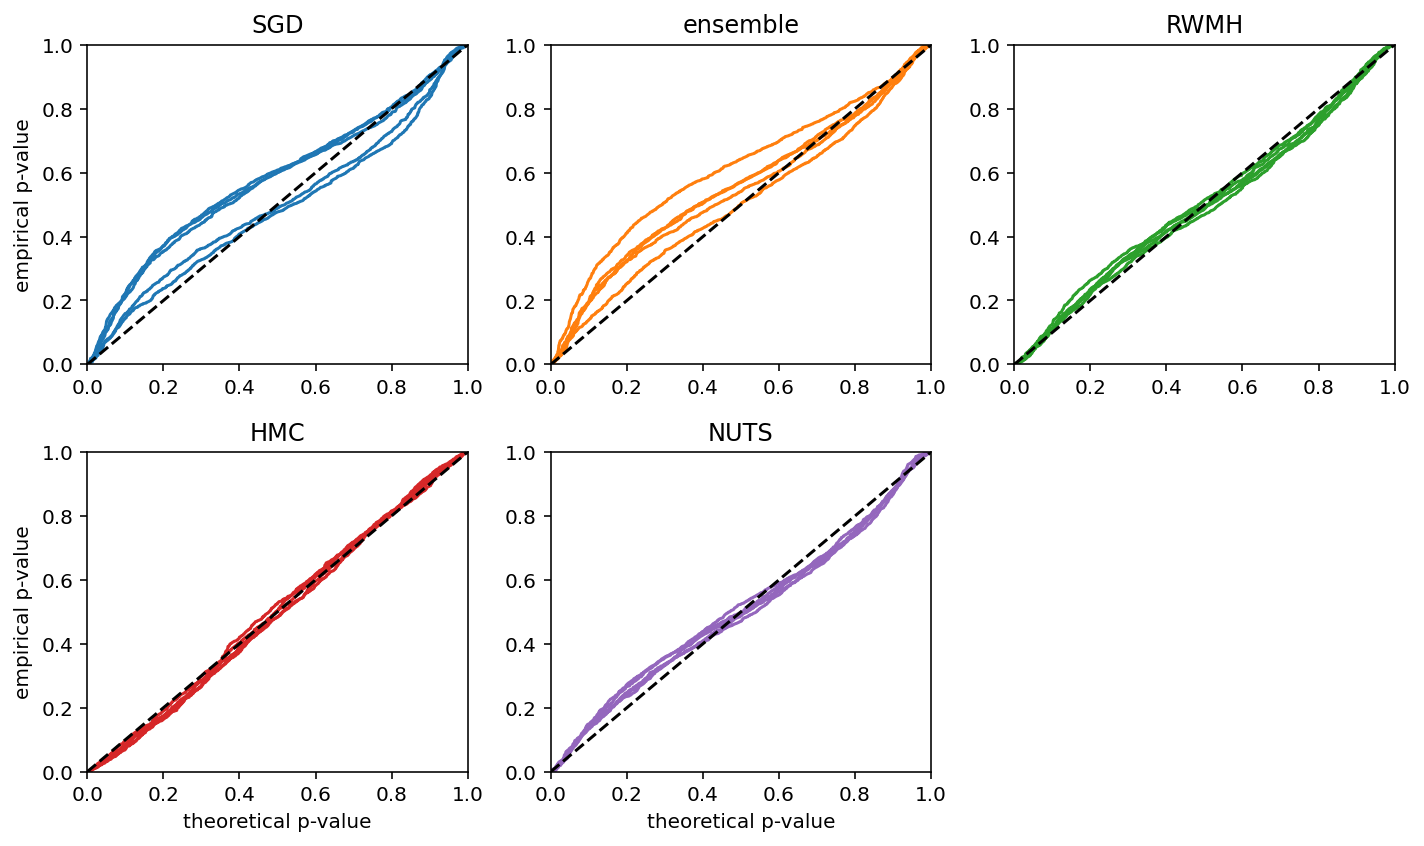

CPU times: user 1min 7s, sys: 3min 24s, total: 4min 31s
Wall time: 7min 53s


In [25]:
%%time
fig, axs = plt.subplots(2, 3, figsize=[10, 6])
axs = axs.flatten()
key = jax.random.PRNGKey(0)
for i, (name, chains) in enumerate(chains_dict.items()):   
    keys = jax.random.split(key, n_chains)
    pvals = jax.pmap(get_response_pvals)(keys, chains[:, -1, None])
    for j in range(n_chains):
        axs[i].plot(jnp.linspace(0, 1, len(y_test)), jnp.sort(pvals[j]), label=name, color=f'C{i}')
    axs[i].plot([0, 1], [0, 1], c='black', ls='--')
    axs[i].set_xlim([0, 1])
    axs[i].set_ylim([0, 1])
    axs[i].set_title(name)
    if i in [3, 4]: axs[i].set_xlabel('theoretical p-value')
    if i in [0, 3]: axs[i].set_ylabel('empirical p-value')

axs[-1].axis('off')
plt.tight_layout()
plt.savefig('plots/uci_residuals_pvals.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## MSE

In [26]:
for i, (name, chains) in enumerate(chains_dict.items()):
    
    def mse_fn(chain):
        # generate samples
        samples = utils.sample_from_chain(predict_fn, key, x_test, chain)

        # estimate mean
        y_hat = samples.mean(1)
        
        # compute mean error
        mse = ((y_test - y_hat)**2).mean()
        return mse
    
    mse = jax.pmap(mse_fn)(chains)
    c = 10**4
    print(f'{name}, {c*mse.mean():.2f} ± {c*mse.std():.2f}')

SGD, 5.20 ± 1.43
ensemble, 3.77 ± 0.24
RWMH, 3.12 ± 1.27
HMC, 0.55 ± 0.27
NUTS, 4.99 ± 1.47


## Likelihood

In [27]:
def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    likelihood_vmap = jax.vmap(log_likelihood_fn, [0, None, None])
    log_likelihood = likelihood_vmap(chain, x_test, y_test)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood

for i, (name, chains) in enumerate(chains_dict.items()):
    lp = jax.vmap(log_prior_fn)(chain).mean()
    ll = jax.pmap(chain_to_loglike)(chains)
    # print(f'{name:<8}: prior={lp:.0f}, likelihood={ll:.0f}')
    print(f'{name}: {ll.mean():.0f} ± {ll.std():.0f}')

SGD: 3409 ± 53
ensemble: 3456 ± 23
RWMH: 4216 ± 85
HMC: 5857 ± 83
NUTS: 3539 ± 69


## Distribution of parameters

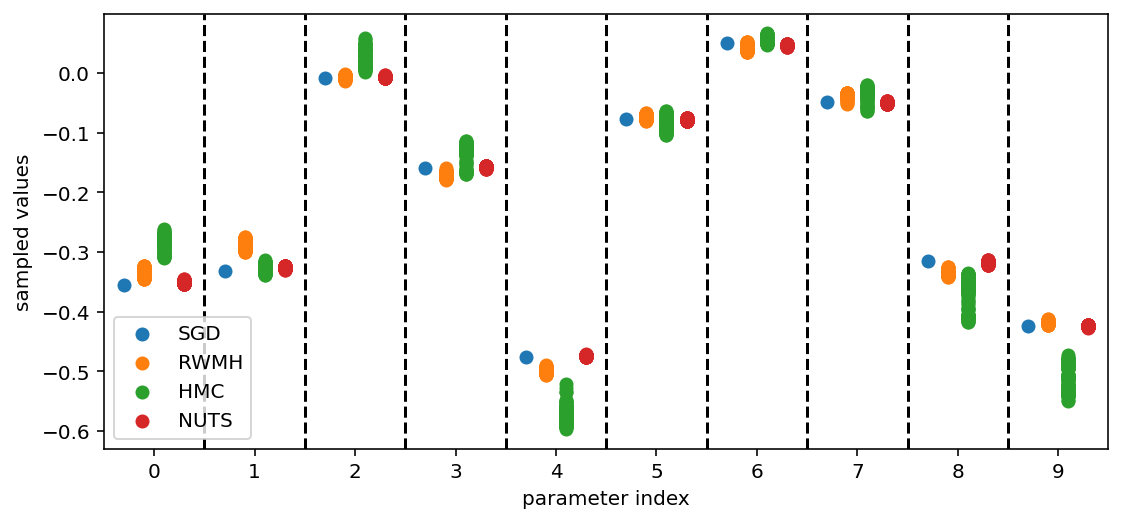

In [28]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['SGD', 'RWMH', 'HMC', 'NUTS']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    chain = chains[0]
    y_ = chain[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('parameter index')
ax.set_ylabel('sampled values')
ax.legend(loc='lower left')
plt.savefig('plots/uci_param_distribution.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

## $\hat{R}$

In [56]:
f_param = lambda params: params
f_pred = lambda params: predict_fn(x_test, params)[:, 0]
f_dict = {'parameter space': f_param, 'prediciton space': f_pred}

for domain, f in f_dict.items():
    print(domain)
    chains_to_show = ['RWMH', 'HMC', 'NUTS']
    for i, name in enumerate(chains_to_show):
        chains = chains_dict[name]
        r = metrics.r_hat(chains, f)
        print(f'{name},  {r.mean():.1f}')

parameter space
RWMH,  30.9
HMC,  9.2
NUTS,  102.4
prediciton space
RWMH,  2.6
HMC,  1.4
NUTS,  5.8
